In [1]:
%pip install pandas


Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import typing 

import pandas as pd

# Constants and Data

In [3]:
modnames= ["H", "D", "He", "Be", "C", "O"]
B_s = np.array([1,0.8888, 0.64, 0.36, 0.2840, 0.2215]) # squared Geometric-Arithmetic Mean Masses (β) for different moderators
N_s = np.array([15., 20., 34., 70., 92., 121.])
N_PAPER_s = np.array([21., 25., 38., 73., 95., 124.])
n_nucleons = np.array([1.,2, 4., 9., 12., 16. ]) # reference:  http://labman.phys.utk.edu/phys222core/modules/m12/nuclear_properties.html
D_s = np.power(n_nucleons, 1/3) + 1 # cube root of # nucleons + 1 

# search space for optimal scatter angle
xdata = np.linspace(np.pi/2.0, np.pi,1001)


In [4]:
def n_collis(psi, beta, k_f_i_rat= (1.0/2e6)):
    """
    return vector of N collisions for 
    set of Beta values from Reed, 2020 
    
    psi: scattering angle
    beta: squared Geometric-Arithmetic Mean Mass (β) of moderator and neutron: 4*(mM)/(m + M)^2 = 4A/(A+1)^2 (A:atomic number)
    k_f_i_rat: ratio of final to initial kinetic energy (1 eV /20 MeV by default)
    """
    
    log_rat = np.log(k_f_i_rat) # 
    rat = lambda x: 1 -x*(np.cos(psi)**2)  # Equation 8 from reed, 2020
    kprepost = np.apply_along_axis(func1d=rat, axis=0, arr=beta)
    return log_rat/np.log(kprepost)

In [5]:
def collis_loss(psi, beta=B_s, ref=N_s): 
    """
    for single psi value, return loss over beta vectors
    """
    return np.linalg.norm(n_collis(psi, beta) - ref)
    

C:\Users\cl140\AppData\Local\Temp\ipykernel_18308\988891868.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return log_rat/np.log(kprepost)
C:\Users\cl140\AppData\Local\Temp\ipykernel_18308\988891868.py:14: RuntimeWarning: divide by zero encountered in log
  return log_rat/np.log(kprepost)


Text(0.5, 1.0, 'Minimal-Loss Scatter angle: 0.756$\\pi$; 136.08 degrees')

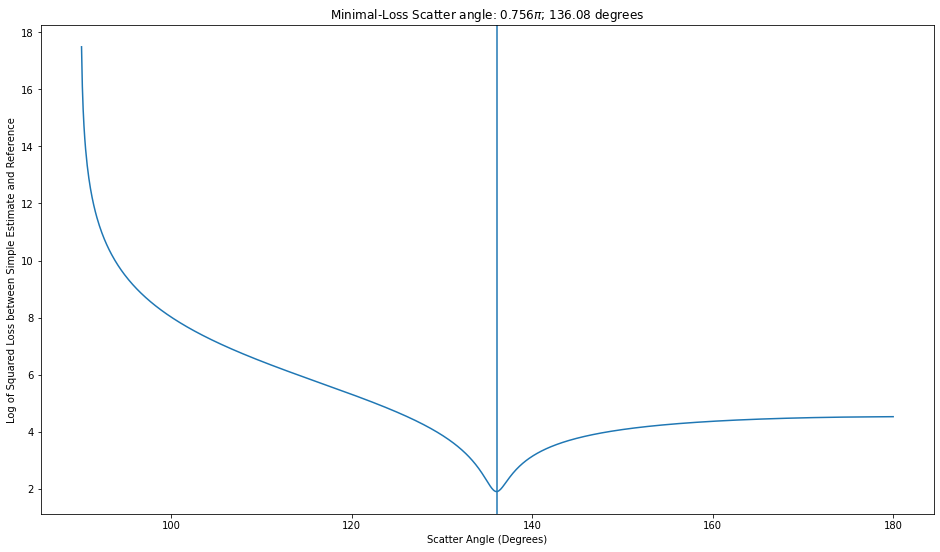

In [6]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(180*xdata/np.pi, [np.log(collis_loss(x)) for x in xdata])
ax.set_ylabel("Log of Squared Loss between Simple Estimate and Reference")
ax.set_xlabel("Scatter Angle (Degrees)")
min_value = np.argmin([np.log(collis_loss(x)) for x in xdata])
ax.axvline(180*xdata[min_value]/np.pi)
ax.set_title(f"Minimal-Loss Scatter angle: {xdata[min_value]/np.pi}$\pi$; {180*xdata[min_value]/np.pi} degrees")

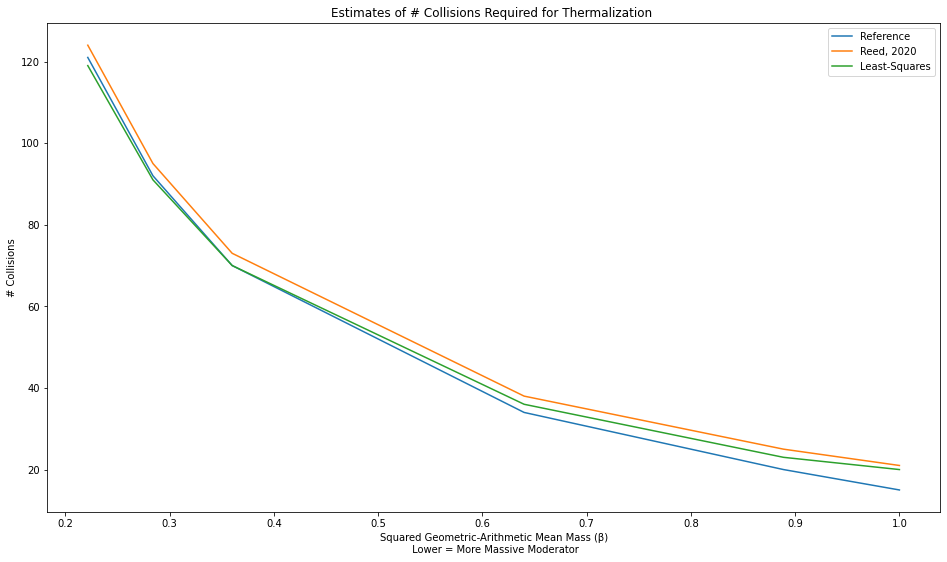

In [7]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(B_s, N_s)
ax.plot(B_s, N_PAPER_s)
ax.plot(B_s, np.round(n_collis(xdata[min_value],B_s)))
ax.set_ylabel("# Collisions")
ax.set_xlabel("Squared Geometric-Arithmetic Mean Mass (β)\n Lower = More Massive Moderator")
ax.legend(['Reference', 'Reed, 2020', 'Least-Squares'])
ax.set_title(f"Estimates of # Collisions Required for Thermalization ")
# ax.set_yscale('log')
plt.show()
plt.close()

In [8]:
np.round(n_collis(xdata[min_value],B_s))

array([ 20.,  23.,  36.,  70.,  91., 119.])

In [9]:
# Function 1: generate random incidence angle
def random_incidence(nrr_sd_rat=1e-6):
    """
    computes angle range using arctan(neutron radius / source distance)
    nrr_sd_rat: float = neutron radius to source distance ratio; 
    
    """
    rng = np.random.default_rng()
    
    max_angle = np.arctan(nrr_sd_rat)
    rand_angle = rng.uniform(-max_angle, max_angle)
    b = (1./nrr_sd_rat)*np.tan(rand_angle)
    return b 



In [10]:
random_incidence()

-0.43707479338909044

In [11]:
def circle_plot(D=2, to_plot=False, use_angle=False, ratio=1e-6):
    """
    Identify scatter angle and 
    Plot schematic collision between neutron and moderator nucleus in a random collision
    D: average radius of moderator nucleus and neutron, in units of neutron radii
    to_plot: boolean of whether to generate a plot
    use_angle: choose impact parameter (offset between neutron and moderator center of mass) based on random collision angle, not random place on moderator diameter
    ratio (when use_angle=True): distance (in neutron radii) between neutron source and moderator nucleus
    """
    # generate random impact parameter
    rng = np.random.default_rng()
    random_place = rng.uniform(-1,1)
    nuc_rad = D - 1 # nuclear radius is expressed in terms of neutron radii
    b = random_incidence(ratio)*nuc_rad if use_angle else random_place*nuc_rad 
    scatter_angle = np.arcsin(b/D)
    # 
    if to_plot:
        fig, ax = plt.subplots()
        ax.set_xlim(-1.8*D, 1.8*D)
        ax.set_ylim(-1.8*D, 1.8*D)
        ax.set_aspect(1)

        ax.add_patch(Circle((0,0),nuc_rad, fill=False))
        ax.add_patch(Circle((-D*np.cos(scatter_angle),b),1, fill=False))
        ax.annotate(xy=(-D*np.cos(scatter_angle),b),xytext=(-D*np.cos(scatter_angle), 0), text="", 
                    arrowprops=dict(arrowstyle="|-|",shrinkA=0, shrinkB=0, alpha=0.4),xycoords='data',textcoords='data')
        ax.arrow(-D*np.cos(scatter_angle),b,2, 0, head_width=0.2)
        ax.arrow(-D*np.cos(scatter_angle),b,-2*np.cos(scatter_angle), 2*np.sin(scatter_angle),head_width=0.2)
        ax.plot(0,0,'.')
        ax.plot(-D*np.cos(scatter_angle),b, '.')
        ax.axline((0,0), (-D*np.cos(scatter_angle),b),ls="--", alpha=0.3)
        ax.annotate(xy=(-D*np.cos(scatter_angle)*1.075,b *1.3), text="$\psi$")
        ax.annotate(xy=(-D*np.cos(scatter_angle), b*0.53), text="$b$", alpha=0.4)
        ax.set_title(f"Scatter angle is {np.round((np.pi - abs(scatter_angle))/np.pi,3)}$\pi$ or {np.round(180*(np.pi - abs(scatter_angle))/np.pi)} deg.")
        plt.axis('off')
        plt.show()
        plt.close()
    return np.pi - abs(scatter_angle)

Simulation Code
- 10000 simulations per moderator type


########################################
H: B = 1.0


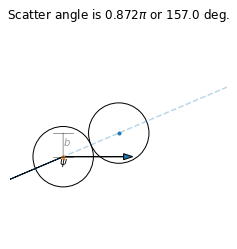

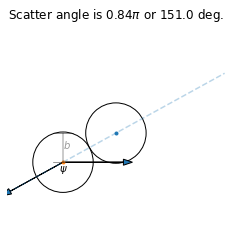

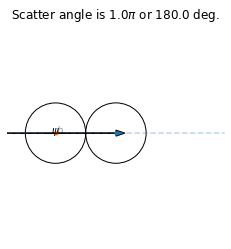

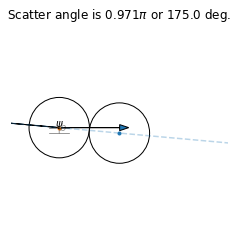

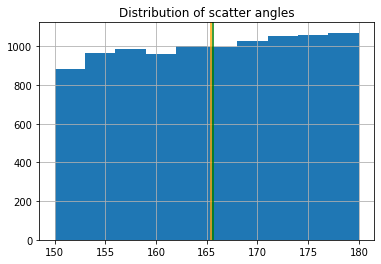

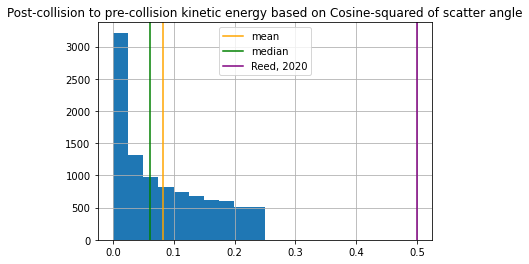

########################################
D: B = 0.8888


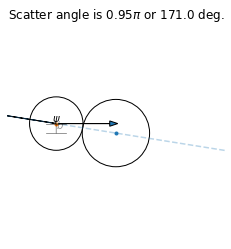

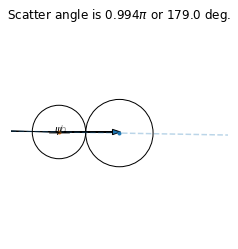

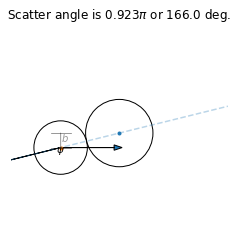

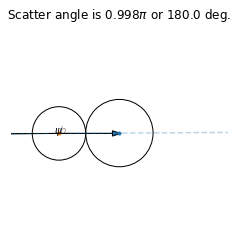

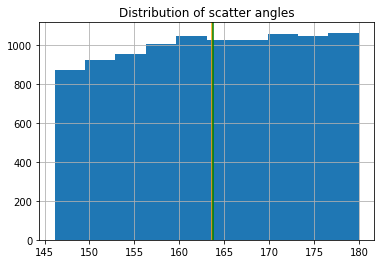

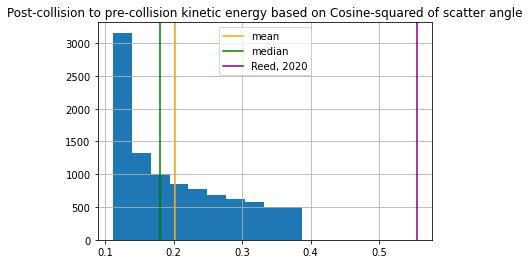

########################################
He: B = 0.64


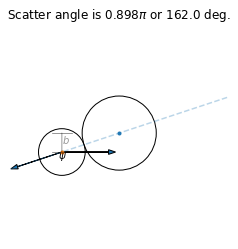

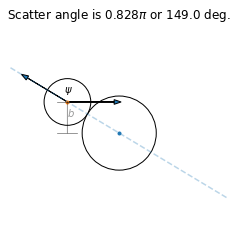

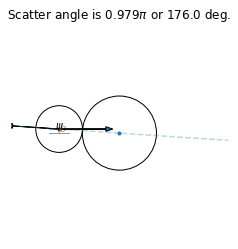

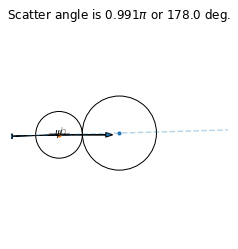

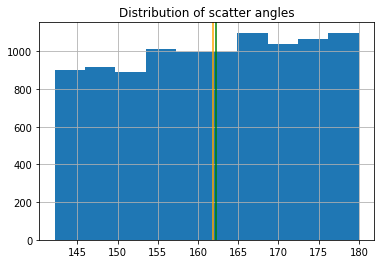

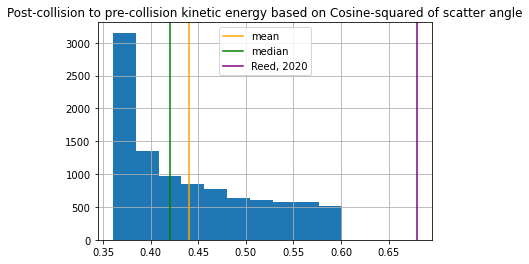

########################################
Be: B = 0.36


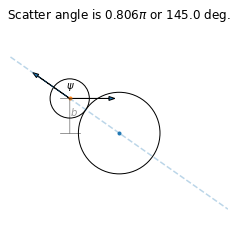

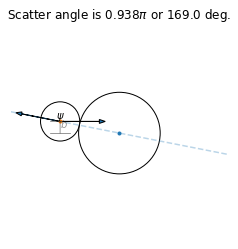

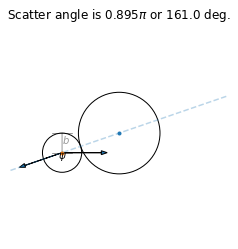

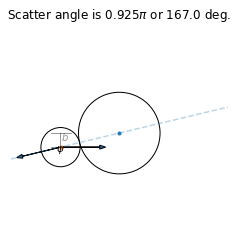

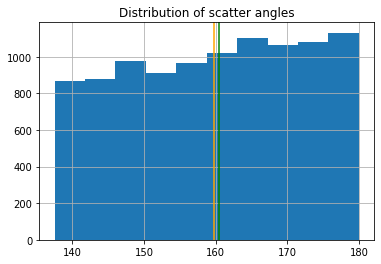

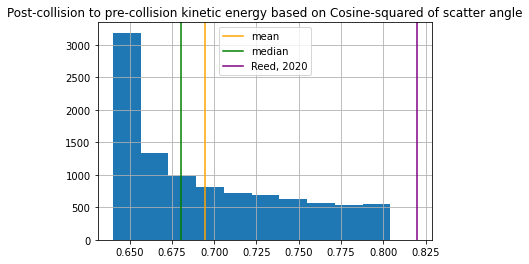

########################################
C: B = 0.284


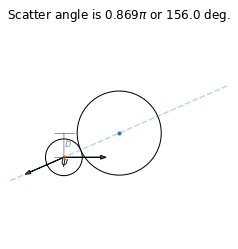

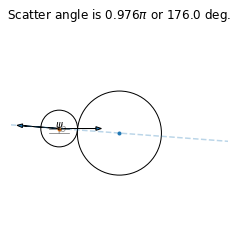

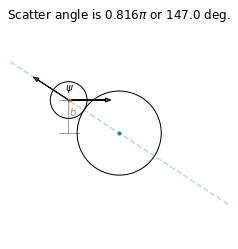

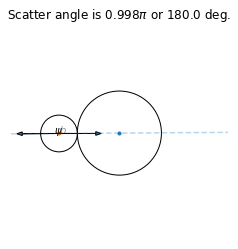

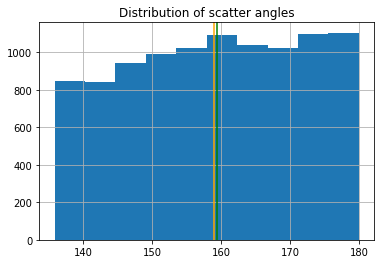

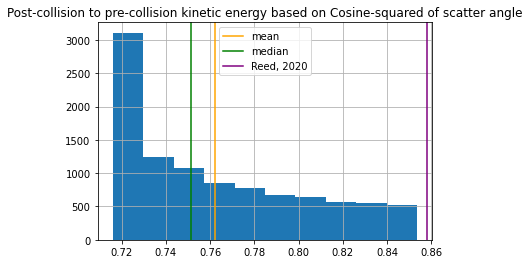

########################################
O: B = 0.2215


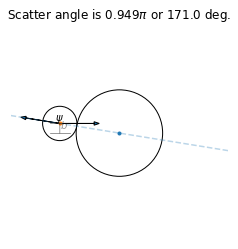

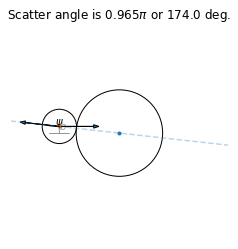

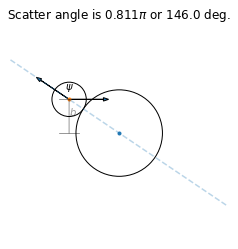

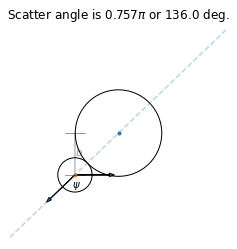

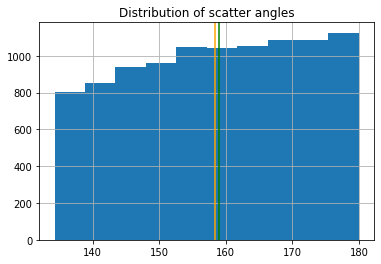

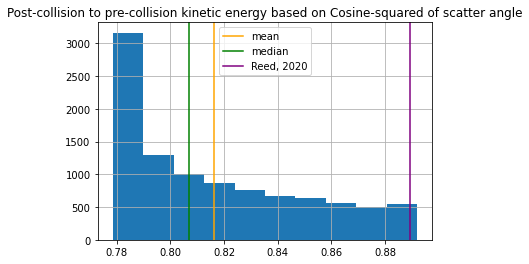

In [12]:
results_dictionary = {}
for idx, name in enumerate(modnames):
    print("#"*40)
    
    B = B_s[idx]
    D = D_s[idx]
    vals = []
    print(f"{name}: B = {B}")

    for x in range(10000):
        y = circle_plot(D=D, to_plot = (x%2967 == 0), use_angle=False, ratio=0.0001)
        vals.append(y)

    fig, ax = plt.subplots()
    (abs(180*pd.Series(vals)/np.pi)).hist(ax=ax)
    ax.axvline((180*pd.Series(vals)/np.pi).mean(), c= 'orange')
    ax.axvline((180*pd.Series(vals)/np.pi).median(), c= 'green')
    ax.set_title("Distribution of scatter angles")
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots()

    pd.Series(vals).apply(lambda x: 1-B*np.cos(x)**2).hist(ax=ax)
    ax.axvline(pd.Series(vals).apply(lambda x: 1-B*np.cos(x)**2).mean(), c= 'orange')
    ax.axvline(pd.Series(vals).apply(lambda x: 1-B*np.cos(x)**2).median(), c= 'green')
    ax.axvline(1-B/2, c="purple")
    ax.set_title("Post-collision to pre-collision kinetic energy based on Cosine-squared of scatter angle")
    ax.legend(['mean','median','Reed, 2020'])
    plt.show()
    plt.close()
    results_dictionary[name] = {"psi":(180*pd.Series(vals)/np.pi).mean(), "n_collisions": np.round(n_collis(pd.Series(vals).mean(),[B])).item()}

In [13]:
results_dictionary

{'H': {'psi': 165.429012517671, 'n_collisions': 5.0},
 'D': {'psi': 163.61118704546476, 'n_collisions': 9.0},
 'He': {'psi': 161.81902759890858, 'n_collisions': 17.0},
 'Be': {'psi': 159.80417358323075, 'n_collisions': 38.0},
 'C': {'psi': 158.9839574390844, 'n_collisions': 51.0},
 'O': {'psi': 158.4360710845924, 'n_collisions': 68.0}}

In [14]:
pd.DataFrame(results_dictionary).T

,psi,n_collisions
H,165.429013,5.0
D,163.611187,9.0
He,161.819028,17.0
Be,159.804174,38.0
C,158.983957,51.0
O,158.436071,68.0
